<a href="https://colab.research.google.com/github/PsorTheDoctor/deep-neural-nets/blob/main/project/owlvit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#OWL-ViT

In [ ]:
!pip install -q roboflow condacolab torch torchmetrics pycocotools
!pip uninstall transformers
!pip install -q transformers
!pip install -q torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!git clone https://github.com/AlexandruSamoila/owl-vit-object-detection.git

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="gJQbiPWBOb1GDvnOLenu")
project = rf.workspace("dnnproject").project("ceres_logo")
dataset = project.version(1).download("coco")

In [ ]:
%cd owl-vit-object-detection/
%ls

In [ ]:
!python3 -m pip install -r requirements.txt

In [ ]:
!python3 scripts/make_coco_subset.py

##Fine-tuning loop

In [96]:
import json
import os
import shutil

import torch
import yaml
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.io import write_png
from tqdm import tqdm

from src.losses import PushPullLoss
from src.dataset import get_dataloaders
from src.models import PostProcess, load_model
from src.train_util import (
    coco_to_model_input, labels_to_classnames, model_output_to_image, update_metrics
)
from src.util import BoxUtil, GeneralLossAccumulator, ProgressFormatter

history = {
    'loss_ce': [],
    'loss_bg': [],
    'loss_bbox': [],
    'loss_giou': [],
}


def get_training_config():
    with open("config.yaml", "r") as stream:
        data = yaml.safe_load(stream)
        return data["training"]


def fit():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    metric = MeanAveragePrecision(iou_type="bbox", class_metrics=True).to(device)
    scaler = torch.cuda.amp.GradScaler()
    general_loss = GeneralLossAccumulator()
    progress_summary = ProgressFormatter()

    if os.path.exists("debug"):
        shutil.rmtree("debug")

    training_cfg = get_training_config()
    train_dataloader, test_dataloader, scales, labelmap = get_dataloaders()

    model = load_model(labelmap, device)

    postprocess = PostProcess(
        confidence_threshold=training_cfg["confidence_threshold"],
        iou_threshold=training_cfg["iou_threshold"],
    )
    criterion = PushPullLoss(
        len(labelmap),
        scales=torch.tensor(scales).to(device)
        if training_cfg["use_class_weight"]
        else None,
    )
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=float(training_cfg["learning_rate"]),
        weight_decay=training_cfg["weight_decay"],
    )
    model.train()
    classMAPs = {v: [] for v in list(labelmap.values())}
    for epoch in range(training_cfg["n_epochs"]):
        if training_cfg["save_eval_images"]:
            os.makedirs(f"debug/{epoch}", exist_ok=True)

        # Train loop
        losses = []
        for i, (image, labels, boxes, metadata) in enumerate(
            tqdm(train_dataloader, ncols=60)
            # train_dataloader
        ):
            optimizer.zero_grad()

            # Prep inputs
            image = image.to(device)
            labels = labels.to(device)
            boxes = coco_to_model_input(boxes.float(), metadata).to(device)

            # Predict
            all_pred_boxes, pred_classes, pred_sims, _ = model(image)
            losses = criterion(pred_sims, labels, all_pred_boxes, boxes)
            loss = (
                losses["loss_ce"]
                + losses["loss_bg"]
                + losses["loss_bbox"]
                + losses["loss_giou"]
            )
            loss.backward()
            optimizer.step()
            general_loss.update(losses)

            for loss_type in ['loss_ce', 'loss_bg', 'loss_bbox', 'loss_giou']:
                history[loss_type].append(float(losses[loss_type].cpu()))

        train_metrics = general_loss.get_values()
        general_loss.reset()

        # Eval loop
        model.eval()
        with torch.no_grad():
            for i, (image, labels, boxes, metadata) in enumerate(
                tqdm(test_dataloader, ncols=60)
            ):
                # Prep inputs
                image = image.to(device)
                labels = labels.to(device)
                boxes = coco_to_model_input(boxes.float(), metadata).to(device)

                # Get predictions and save output
                pred_boxes, pred_classes, pred_class_sims, _ = model(image)
                pred_boxes, pred_classes, scores = postprocess(
                    pred_boxes, pred_class_sims
                )
                # Use only the top 200 boxes to stay consistent with benchmarking
                top = torch.topk(scores, min(200, scores.size(-1)))
                scores = top.values
                inds = top.indices.squeeze(0)

                update_metrics(
                    metric,
                    metadata,
                    pred_boxes[:, inds],
                    pred_classes[:, inds],
                    scores,
                    boxes,
                    labels,
                )
                if training_cfg["save_eval_images"]:
                    pred_classes_with_names = labels_to_classnames(
                        pred_classes, labelmap
                    )
                    pred_boxes = model_output_to_image(pred_boxes.cpu(), metadata)
                    image_with_boxes = BoxUtil.draw_box_on_image(
                        metadata["impath"].pop(),
                        pred_boxes,
                        pred_classes_with_names,
                    )
                    write_png(image_with_boxes, f"debug/{epoch}/{i}.jpg")

        model.pretrained_model.save_pretrained("data")
        print("Computing metrics...")
        val_metrics = metric.compute()
        #for i, p in enumerate(val_metrics["map_per_class"].tolist()):
        label = labelmap[str(0)]
        classMAPs[label].append(val_metrics["map_per_class"].tolist())

        with open("class_maps.json", "w") as f:
            json.dump(classMAPs, f)

        metric.reset()
        progress_summary.update(epoch, train_metrics, val_metrics)
        progress_summary.print()

In [ ]:
fit()

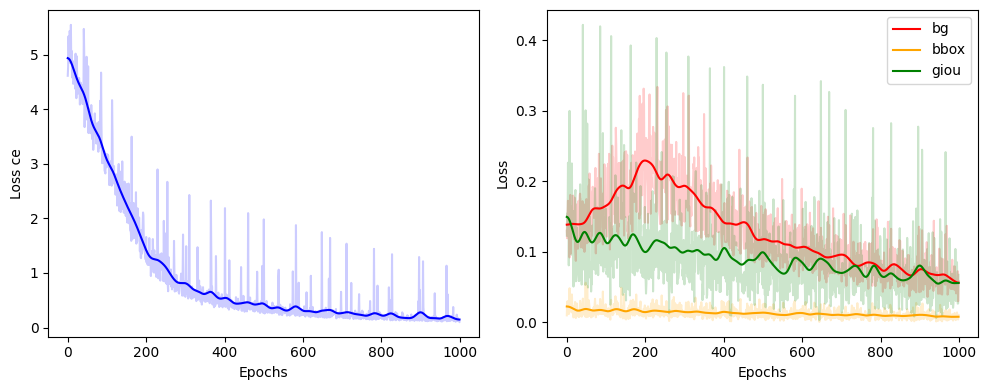

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

sigma = 10
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(history['loss_ce'], alpha=0.2, c='blue')
ax[0].plot(gaussian_filter1d(history['loss_ce'], sigma=sigma), c='blue')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss ce')

ax[1].plot(history['loss_bg'], alpha=0.2, c='red')
ax[1].plot(history['loss_bbox'], alpha=0.2, c='orange')
ax[1].plot(history['loss_giou'], alpha=0.2, c='green')
ax[1].plot(gaussian_filter1d(history['loss_bg'], sigma=sigma), label='bg', c='red')
ax[1].plot(gaussian_filter1d(history['loss_bbox'], sigma=sigma), label='bbox', c='orange')
ax[1].plot(gaussian_filter1d(history['loss_giou'], sigma=sigma), label='giou', c='green')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.tight_layout()
plt.legend()

In [56]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers.utils import send_example_telemetry
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from transformers.image_utils import ImageFeatureExtractionMixin

In [101]:
model = OwlViTForObjectDetection.from_pretrained('data')
processor = OwlViTProcessor.from_pretrained('google/owlvit-base-patch32')

In [102]:
img = Image.open('../ceres_logo-1/test/35_1693141475_jpg.rf.8db56d0dddd21b64363d783b2824fde8.jpg')

In [103]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
inputs = processor(text=['ceres'], images=img, return_tensors="pt").to(device)

for key, val in inputs.items():
  print(f'{key}: {val.shape}')

In [ ]:
model = model.to(device)
model.eval()

with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
  if k not in {'text_model_output', 'vision_model_output'}:
    print(f'{k}: shape of {val.shape}')

print('\nText model outputs')
for k, val in outputs.text_model_output.items():
  print(f'{k}: shape of {val.shape}')

print('\nVision model outputs')
for k, val in outputs.vision_model_output.items():
  print(f'{k}: shape of {val.shape}')

In [106]:
mixin = ImageFeatureExtractionMixin()

image_size = model.config.vision_config.image_size
image = mixin.resize(img, image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

score_threshold = 0.5

logits = torch.max(outputs['logits'][0], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

labels = logits.indices.cpu().detach().numpy()
boxes = outputs['pred_boxes'][0].cpu().detach().numpy()

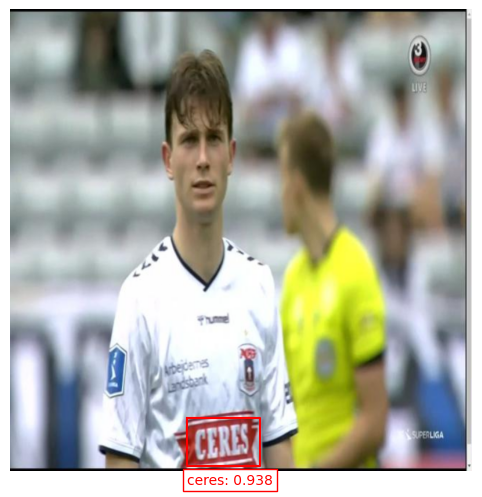

In [107]:
def plot_predictions(input_image, text_queries, scores, boxes, labels):
  fig, ax = plt.subplots(1, 1, figsize=(8, 6))
  ax.imshow(input_image, extent=(0, 1, 1, 0))
  ax.set_axis_off()
  max_score = 0

  for score, box, label in zip(scores, boxes, labels):
    if score < score_threshold:
      continue
    if score > max_score:
      max_score = score
      max_box = box
      max_label = label

  cx, cy, w, h = max_box
  ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
          [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], 'r')
  ax.text(
      cx - w / 2,
      cy + h / 2 + 0.015,
      f"{text_queries[max_label]}: {max_score:1.3f}",
      ha="left",
      va="top",
      color="red",
      bbox={
          "facecolor": "white",
          "edgecolor": "red",
          "boxstyle": "square,pad=.3"
  })

plot_predictions(input_image, ['ceres'], scores, boxes, labels)